In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Data

In [2]:
df_adult = pd.read_csv('adult.csv')
df_adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Missing Value

Missing value in this dataset marked with "?"  
The Missing Variable:
* workclass
* occupation
* native.country

## Preprocessing

preprocess scheme:
* drop: fnlwgt
* one hot encoding : relationship, race, sex
* binary encoding : workclass, marital status, occupation, native country  
* ordinal encoding : education (already encoded)
* no treatment : the rest

In [4]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'NC', missing_values='?')),
                                    ('binary encoder',ce.BinaryEncoder())
])

transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),['relationship','race','sex']),
                                 ('binary encoder',binary_encoder_pipeline,['workclass','marital.status','occupation','native.country'])
                                ], remainder = 'passthrough')

In [5]:
transformer.fit_transform(df_adult)

array([[1.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       [1.0, 0.0, 0.0, ..., 4356, 18, '<=50K'],
       [0.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 40, '>50K'],
       [0.0, 0.0, 0.0, ..., 0, 40, '<=50K'],
       [0.0, 0.0, 1.0, ..., 0, 20, '<=50K']], dtype=object)

In [6]:
X = df_adult.drop(columns = ['fnlwgt','income','education'])
y = np.where(df_adult['income']=='>50K',1,0)

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    stratify = y, 
    random_state = 10)

## Model Selection

In [10]:
model_tree= DecisionTreeClassifier(max_depth=3)

model_ada= AdaBoostClassifier(model_tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10)

model_gbc=GradientBoostingClassifier(    
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10)

model_xgbc=XGBClassifier( 
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10)

In [12]:
estimator=Pipeline([('preprocess',transformer),('model',model_tree)])

hyperparam_space={'model':[model_tree,model_ada,model_gbc,model_xgbc]}

In [13]:
skfold= StratifiedKFold(n_splits=5)

grid_search= GridSearchCV(estimator,
    param_grid= hyperparam_space,
    cv=skfold,
    n_jobs=-1,
    scoring='f1')

In [14]:
grid_search.fit(X_train_val,y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
                

In [30]:
pd.DataFrame(grid_search.cv_results_)[['param_model','mean_test_score','std_test_score']]

,param_model,mean_test_score,std_test_score
0,DecisionTreeClassifier(max_depth=3),0.605702,0.007411
1,AdaBoostClassifier(base_estimator=DecisionTree...,0.705721,0.013265
2,"GradientBoostingClassifier(n_estimators=200, r...",0.698576,0.013179
3,"XGBClassifier(base_score=None, booster=None, c...",0.698875,0.013476


In [15]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score 0.7057207928319411
best param {'model': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)}


In [16]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



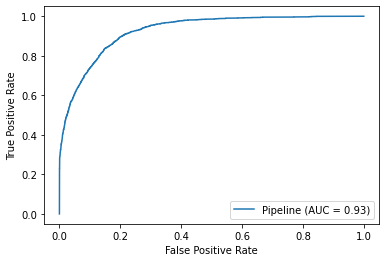

In [17]:
plot_roc_curve(grid_search.best_estimator_, X_test, y_test)

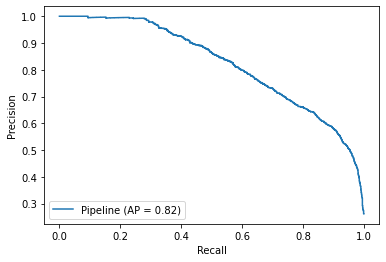

In [18]:
plot_precision_recall_curve(grid_search.best_estimator_, X_test, y_test)

## Hyperparameter Tuning for The Selected Model  
based of previous step, Adaboost is selected.

In [19]:
model_tree = DecisionTreeClassifier(max_depth = 3)

model_ada = AdaBoostClassifier(
    model_tree,
    n_estimators = 200,
    learning_rate = 0.1,
    random_state = 10
)

estimator = Pipeline([
                      ('preprocess',transformer),
                      ('clf',model_ada)                 
])

hyperparam_space = [
                    {'clf__learning_rate':[0.1],'clf__n_estimators':[200],'clf__base_estimator__max_depth':[3,4,5]}, 
                    {'clf__learning_rate':[0.05],'clf__n_estimators':[400],'clf__base_estimator__max_depth':[3,4,5]},
                    {'clf__learning_rate':[0.01],'clf__n_estimators':[2000],'clf__base_estimator__max_depth':[3,4,5]},
                    {'clf__learning_rate':[0.005],'clf__n_estimators':[4000],'clf__base_estimator__max_depth':[3,4,5]}
]
# Perhatikan cara penulisan hyperparam spacenya

skfold = StratifiedKFold(n_splits = 5)

grid_search_ada = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skfold, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [20]:
estimator.get_params().keys() # Untuk melihat penulisan namaparameter yg bisa ditunning

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'clf', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__one hot encoder', 'preprocess__binary encoder', 'preprocess__one hot encoder__categories', 'preprocess__one hot encoder__drop', 'preprocess__one hot encoder__dtype', 'preprocess__one hot encoder__handle_unknown', 'preprocess__one hot encoder__sparse', 'preprocess__binary encoder__memory', 'preprocess__binary encoder__steps', 'preprocess__binary encoder__verbose', 'preprocess__binary encoder__imputer', 'preprocess__binary encoder__binary encoder', 'preprocess__binary encoder__imputer__add_indicator', 'preprocess__binary encoder__imputer__copy', 'preprocess__binary encoder__imputer__fill_value', 'preprocess__binary encoder__imputer__missing_values', 'preprocess__binary encoder__imputer__strategy', 'preprocess__binary encoder__imputer__verbose', 'prepro

In [21]:
grid_search_ada.fit(X_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
                

In [22]:
print('best score',grid_search_ada.best_score_)
print('best param',grid_search_ada.best_params_)

best score 0.7073718800454054
best param {'clf__base_estimator__max_depth': 4, 'clf__learning_rate': 0.1, 'clf__n_estimators': 200}


In [31]:
# before vs after tunning

In [32]:
model_tree= DecisionTreeClassifier(max_depth=3)

model_ada= AdaBoostClassifier(model_tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10)

In [33]:
estimator= Pipeline([('transformer', transformer),('model',model_ada)])
estimator.fit(X_train_val,y_train_val)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                     

In [34]:
y_pred=estimator.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [23]:
grid_search_ada.best_estimator_.fit(X_train_val,y_train_val)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                      

In [24]:
y_pred = grid_search_ada.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.77      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



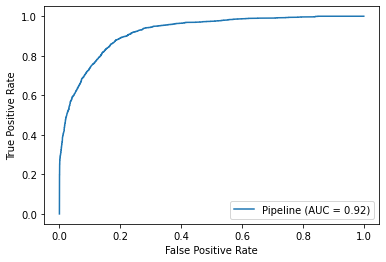

In [25]:
plot_roc_curve(grid_search_ada.best_estimator_, X_test, y_test)

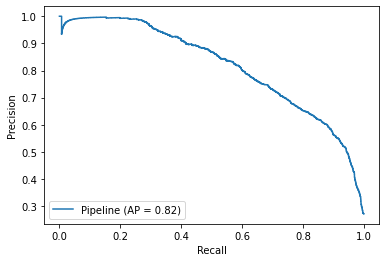

In [26]:
plot_precision_recall_curve(grid_search_ada.best_estimator_, X_test, y_test)

Hyperparameter tunning tidak meningkatkan performa model.